In [16]:
import numpy as np, ast, pandas as pd, networkx as nx, matplotlib.pyplot as plt
from calibration_helpers import load_payload
from networkx.drawing.nx_agraph import graphviz_layout

In [17]:
df = pd.read_csv("results/ibm_marrakesh_qv_3.csv")

In [30]:
def coupling_to_graph(coupling_map):
    G = nx.Graph()
    # coupling_map entries may be lists; normalize to tuples
    G.add_edges_from((int(a), int(b)) for a, b in coupling_map)
    return G


def node_scores_from_triples(df, score_col="mean_HOP"):
    node_vals = {}
    node_counts = {}

    for index, row in df.iterrows():

        # 1) Convert string into tuple 
        triple = ast.literal_eval(row["triple"])

        # 2) Get the score of this triple
        score = float(row["mean_HOP"])

        # 3) Go through each node in the triple
        for node in triple:

            # If this is the first time we see this node
            if node not in node_vals:
                node_vals[node] = []
                node_counts[node] = 0

            # Add this triple's score to the node
            node_vals[node].append(score)

            # Increase how many times this node appeared
            node_counts[node] += 1


    score = {n: float(np.mean(v)) for n, v in node_vals.items()}

    return score, node_counts


def plot_node_heatmap(G, pos, node_score, title="Node heatmap (mean_HOP)"):
    nodes = list(G.nodes())
    vals = np.array([node_score.get(n, np.nan) for n in nodes], dtype=float)

    # Use only finite values for color scaling
    finite = np.isfinite(vals)
    if not finite.any():
        raise ValueError("No finite node scores to plot (all NaN/inf).")

    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.viridis

    fig, ax = plt.subplots(figsize=(10, 8))

    nx.draw(
        G, pos, ax=ax,
        node_color=vals,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        with_labels=True,
        node_size=350,
        width=1
    )

    # Properly attach a mappable to an Axes for the colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(vals[finite])  
    fig.colorbar(sm, ax=ax, label="mean_HOP (aggregated)")

    ax.set_title(title)
    ax.set_axis_off()
    fig.tight_layout()
    plt.show()

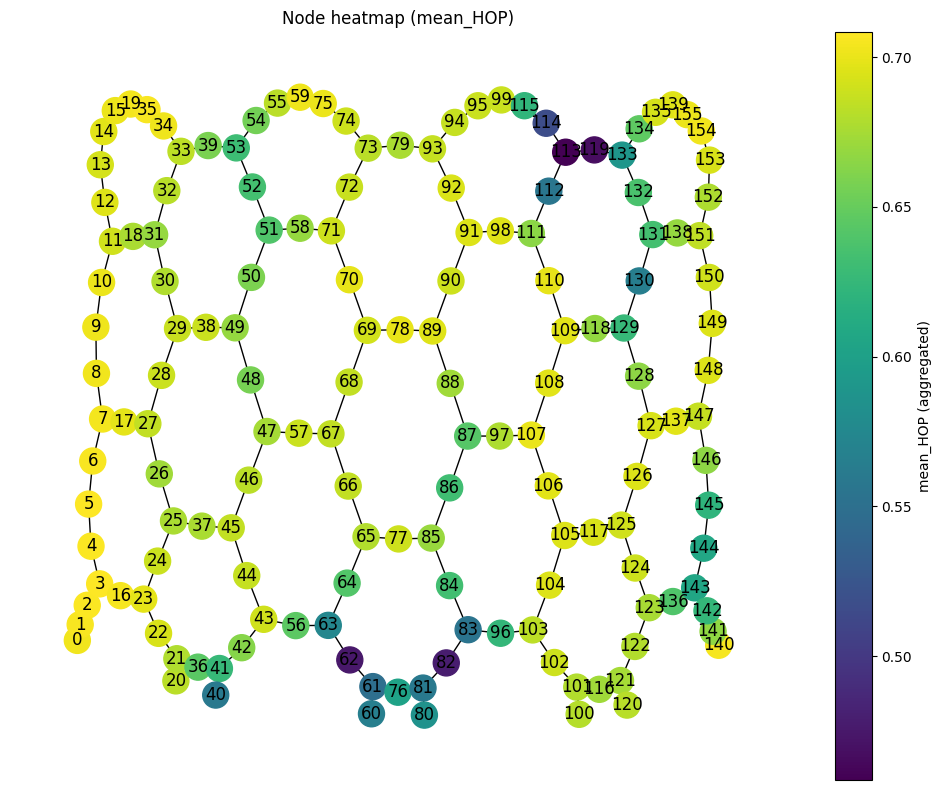

In [31]:
calibration = "calibrations/ibm_marrakesh/20260129_101824.json"
payload = load_payload(calibration)
coupling_map = payload["coupling_map"]

G = coupling_to_graph(coupling_map)
pos = graphviz_layout(G, prog="sfdp")

node_score, node_counts = node_scores_from_triples(df)
plot_node_heatmap(G, pos, node_score)